In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima

In [130]:
data = pd.read_csv("../../datas/IEA Global EV Data 2024 new.csv")
data

,region,category,parameter,mode,powertrain,year,unit,value,percentage
0,Austria,Historical,EV stock,Cars,BEV,2010,Vehicles,350,"35000,00%"
1,Austria,Historical,EV stock share,Cars,EV,2010,percent,789.999.961.853,"78999996185300,00%"
2,Belgium,Historical,EV stock,Buses,BEV,2010,Vehicles,3,"300,00%"
3,Belgium,Historical,EV sales,Vans,BEV,2010,Vehicles,7,"700,00%"
4,Belgium,Historical,EV stock,Vans,BEV,2010,Vehicles,62,"6200,00%"
...,...,...,...,...,...,...,...,...,...
12649,World,Projection-STEPS,EV sales share,Cars,EV,2035,percent,55,"5500,00%"
12650,World,Projection-STEPS,EV stock share,Cars,EV,2035,percent,31,"3100,00%"
12651,World,Projection-APS,EV charging points,EV,Publicly available fast,2035,charging points,9400000,"940000000,00%"
12652,World,Projection-APS,EV charging points,EV,Publicly available slow,2035,charging points,15000000,"1500000000,00%"


In [131]:
data['value'] = pd.to_numeric(data['value'], errors='coerce')
data['percentage'] = pd.to_numeric(data['percentage'], errors='coerce')

In [132]:
data.isnull().sum()

region            0
category          0
parameter         0
mode              0
powertrain        0
year              0
unit              0
value          3233
percentage    12616
dtype: int64

In [133]:
data.dropna(inplace=True)

In [134]:
data_group = data[["year", "value"]].groupby("year").sum().reset_index()
data_group

,year,value
0,2011,0.25
1,2014,0.50
2,2015,0.25
3,2016,3.50
4,2017,1.25
5,2018,0.75
6,2019,1.25
7,2020,1.75
8,2021,3.00
9,2022,1.50


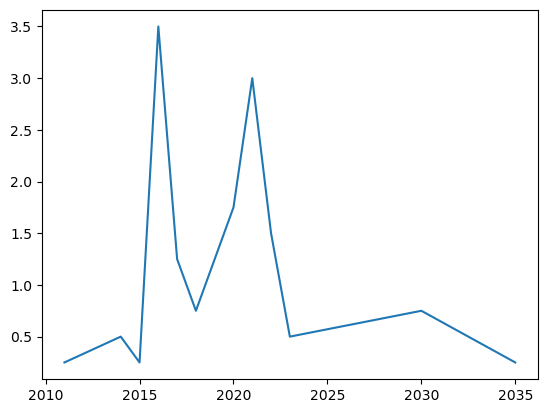

In [135]:
plt.plot(data_group["year"], data_group["value"])
plt.show()

In [136]:
train = data_group[data_group["year"] <= 2023]
test = data_group[data_group["year"] >= 2023]
train, test

(    year  value
 0   2011   0.25
 1   2014   0.50
 2   2015   0.25
 3   2016   3.50
 4   2017   1.25
 5   2018   0.75
 6   2019   1.25
 7   2020   1.75
 8   2021   3.00
 9   2022   1.50
 10  2023   0.50,
     year  value
 10  2023   0.50
 11  2030   0.75
 12  2035   0.25)

In [137]:
train_diff_1 = train["value"].diff().dropna()
adfuller(train_diff_1)

(-3.322376869678028,
 0.013907381219126266,
 3,
 6,
 {'1%': -5.354256481481482,
  '5%': -3.6462381481481483,
  '10%': -2.901197777777778},
 13.386246362519806)

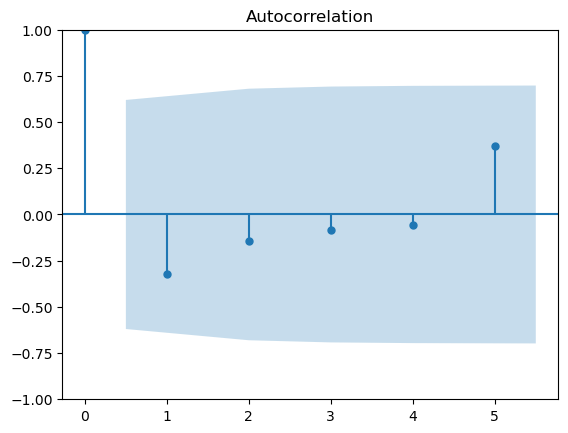

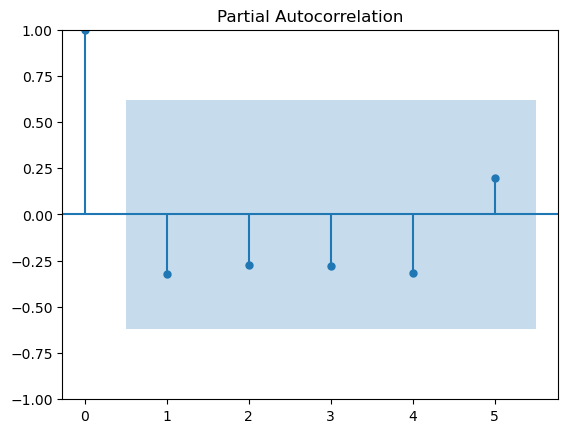

In [138]:
plot_acf(train_diff_1)
plt.show()
plot_pacf(train_diff_1)
plt.show()

## Check forecasting in 

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -17.552
Date:                Tue, 19 Nov 2024   AIC                             41.105
Time:                        17:46:00   BIC                             41.697
Sample:                             0   HQIC                            39.828
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2347      0.564     -0.416      0.678      -1.341       0.871
ma.L1         -0.9990    308.502     -0.003      0.997    -605.652     603.654
sigma2         2.1362    657.455      0.003      0.9

C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarni

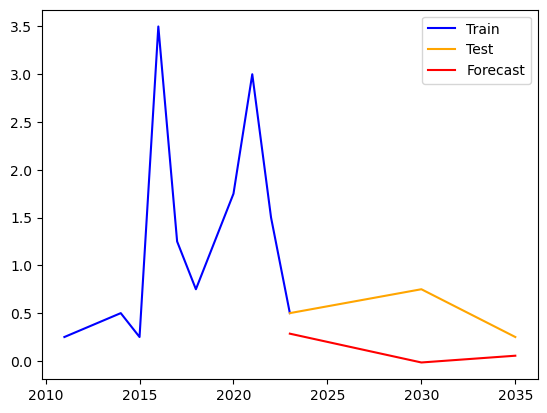

In [223]:
model_fit = ARIMA(train_diff_1, order=(1, 1, 1)).fit()
print(model_fit.summary())
forecast = model_fit.forecast(steps=len(test))

plt.plot(train["year"], train["value"], label="Train", color = "blue")
plt.plot(test["year"], test["value"], label="Test", color = "orange")
plt.plot(test["year"], forecast, label="Forecast", color = "red")
plt.legend()
plt.show()

In [222]:
mean_squared_error(test["value"], forecast), mean_absolute_error(test["value"], forecast), mean_absolute_percentage_error(test["value"], forecast)

(1.0244163286939914, 0.8274959591149648, 2.3628053091261276)

ARIMA(3, 0, 2): (1.0244163286939914, 0.8274959591149648, 2.3628053091261276) <br/>
ARIMA(1, 1, 2): (0.40697182114692954, 0.5722009145098567, 1.3275423228337007) <br/>
ARIMA(1, 0, 1): (0.37306307270709005, 0.5418028490845743, 1.0486537413045798) <br/>
ARIMA(0, 0, 0): (0.2672964185877666, 0.4750050019958736, 0.9389011159899132) <br/>
ARIMA(2, 1, 1): (0.2531815420983404, 0.4832155621571108, 1.0562684452227664) <br/>
ARIMA(1, 0, 0): (0.23168380763421972, 0.37097182184772115, 0.6798463135539675) <br/>
ARIMA(1, 1, 1): (0.2240230576390695, 0.39240985221580865, 0.744984671530755) <br/>




In [220]:
auto_arima(train_diff_1, seasonal=False, stepwise=False)

# Auto arima model with seasonal=False and stepwise=False gives the best model as ARIMA(1, 0, 0) and ARIMA(0, 0, 0)

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


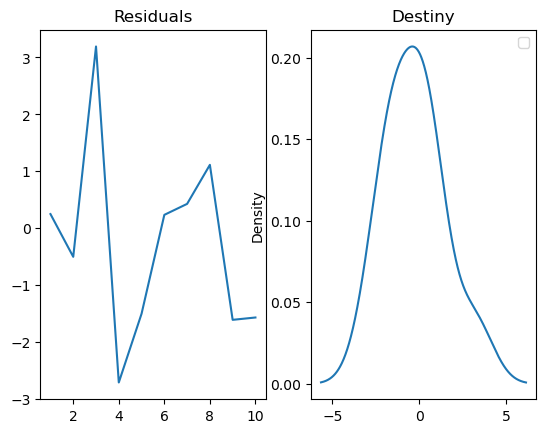

In [143]:
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Destiny", kind = "kde", ax = ax[1])
plt.show()

C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   10
Model:                 ARIMA(5, 2, 5)   Log Likelihood                 -12.311
Date:                Tue, 19 Nov 2024   AIC                             46.621
Time:                        17:46:38   BIC                             47.495
Sample:                             0   HQIC                            40.728
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1868      0.356     -6.142      0.000      -2.885      -1.489
ar.L2         -2.6884      1.125     -2.390      0.017      -4.893      -0.484
ar.L3         -2.6854      0.948     -2.833      0.0

C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


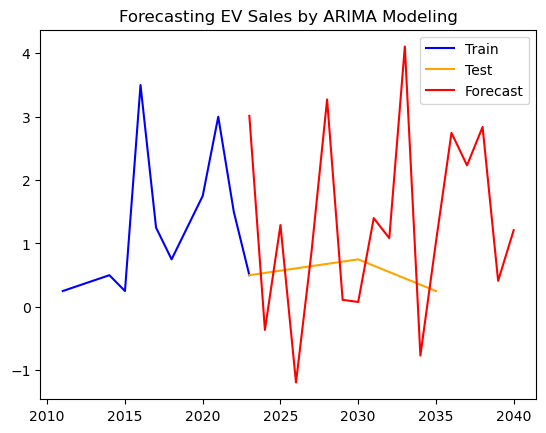

In [224]:
model_fit = ARIMA(train_diff_1, order=(5, 2, 5)).fit()
print(model_fit.summary())

forecast_years = np.arange(2023, 2041)
forecast_steps = len(forecast_years)
forecast = model_fit.forecast(steps=forecast_steps)

plt.plot(train["year"], train["value"], label="Train", color = "blue")
plt.plot(test["year"], test["value"], label="Test", color = "orange")
plt.plot(forecast_years, forecast, label="Forecast", color = "red")
plt.title("Forecasting EV Sales by ARIMA Modeling")
plt.legend()
plt.show()

In [225]:
mean_squared_error(forecast_years, forecast), mean_absolute_error(forecast_years, forecast), mean_absolute_percentage_error(forecast_years, forecast)

(4121745.6942141172, 2030.201794474657, 0.9993612754698193)

ARIMA(5, 1, 5): (4126892.6617287826, 2031.4681717732476, 0.9999841028224498) <br/>
ARIMA(1, 1, 1): (4126808.942116284, 2031.4482102828506, 0.9999744832907275) <br/>
ARIMA(5, 1, 1): (4126565.781916346, 2031.387602500944, 0.9999443919334582) <br/>
ARIMA(3, 0, 2): (4126448.4943599724, 2031.358903730733, 0.9999303484982894) <br/>
ARIMA(5, 2, 5): (4121745.6942141172, 2030.201794474657, 0.9993612754698193) <br/>






In [217]:
auto_arima(train_diff_1, seasonal=False, stepwise=False)

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

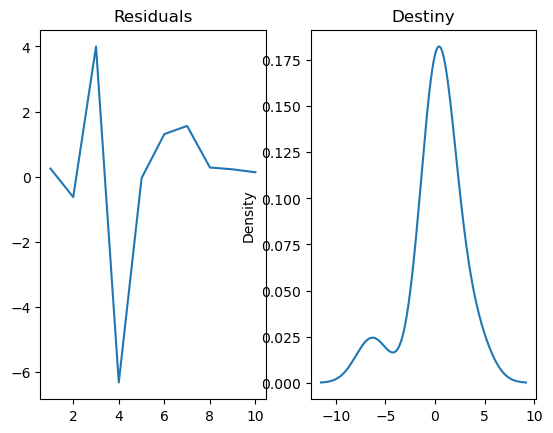

In [229]:
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Destiny", kind = "kde", ax = ax[1])
plt.show()